In [1]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_steane
from encoded.LST import int_to_binary

## Computer parameters

In [37]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85]
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [38]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

## Analog version

In [ ]:


n_shots = 100_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


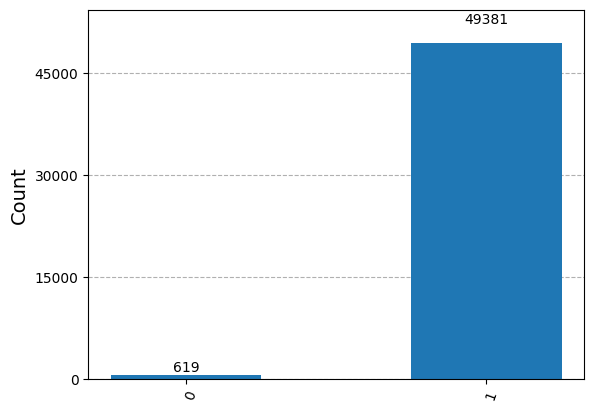

In [40]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [13]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.75 %


## Encoding the Steane code (k = 2)

In [41]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1

# Steane codewords (you can get them by simulating the dj_steane without noise)
logical_1_codeword = ["1110000","0101010","1000110","0100101","0010011","1001001","1111111","0011100"]
logical_0_codeword = ["1011010","0001111","0000000","0110110","1101100","1010101","0111001","1100011"]


k = 2
qreg = cirq.LineQubit.range(7*k)
circuit= dj_steane(qreg,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:7*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    #initial_layout=layout[7],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()

OrderedDict([('rz', 289), ('sx', 157), ('ecr', 85), ('x', 16), ('measure', 7)])

In [42]:
compiled_raw.draw(fold = -1)

global phase: π/2
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [43]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

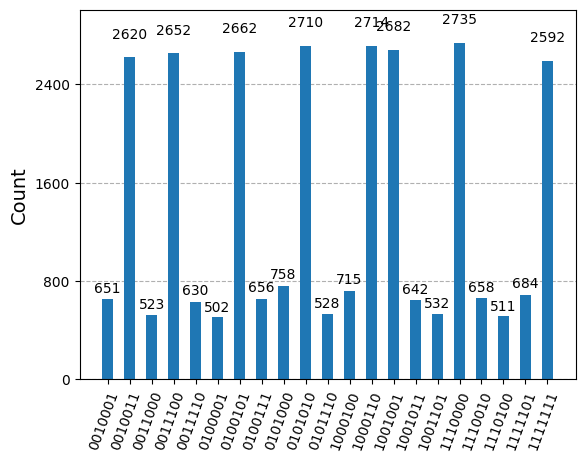

In [45]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [47]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  98.13981260334374 %
